In [1]:
import matplotlib.pyplot as plt

import numpy as np

import csv
import json


from util import load_spectrum_file, load_LCS_bands

try:
    from snsphd import viz
    # from snsphd.hist import SplineTool
    Colors, swatches = viz.phd_style(jupyterStyle=True, svg_mode=True)
except ImportError:
    pass

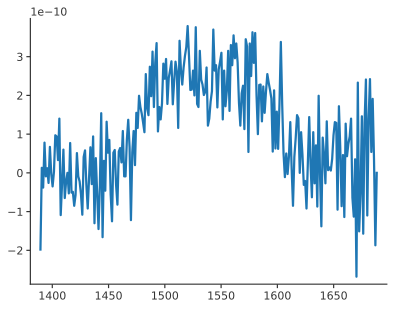

In [2]:
file = 38

wavelengths, vals = load_spectrum_file(f"..//data//WaveData20230607_0{file}.csv")
plt.plot(wavelengths, vals)

In [36]:
import matplotlib
cmap = matplotlib.colormaps.get_cmap('viridis')

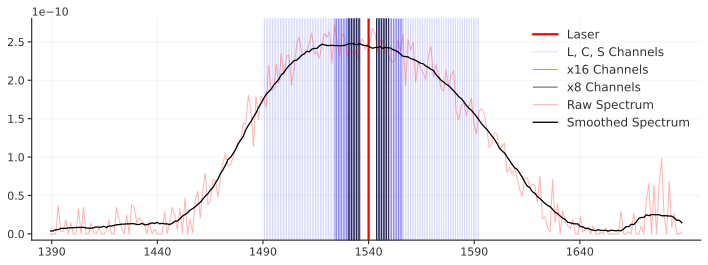

In [54]:
good_files = [10, 11, 12, 13, 14, 15, 16, 17, 18, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
values = []
wavelengths = []

## SPDC on
for file in good_files:
    name_path = f"..//data//WaveData20230607_0{file}.csv"
    wavelengths, vals = load_spectrum_file(name_path)
    values.append(vals)
# print(np.array(values))

## SPDC off
off_values = []
good_files = [19, 20, 21, 22, 23, 24, 25, 26, 39, 40]
for file in good_files:
    name_path = f"..//data//WaveData20230607_0{file}.csv"
    wavelengths, vals = load_spectrum_file(name_path)
    off_values.append(vals)


# the 'off' data appears pretty uniform, so 'create' more off-data
# with a psuedo-bootstrap method

for i in range(5):
    for val in off_values.copy():
        off_values.append(np.roll(val, np.random.randint(20)))



zero_subtracted = np.average(values, axis=0) - np.average(off_values, axis=0)
zero_subtracted[zero_subtracted < 0] = 0
# spline = SplineTool(np.array(zero_subtracted), np.array(wavelengths))

kernel_size = 20
kernel = np.ones(kernel_size) / kernel_size
data_convolved = np.convolve(zero_subtracted, kernel, mode='same')


fig, ax = plt.subplots(1,1, figsize=(12,4))


ax.axvline(1540, color='r', label="Laser")

signal_full, idler_full = load_LCS_bands('LCS_bands.csv')
idler_8x = idler_full[-8:]
signal_8x = signal_full[-8:]

idler_16x = idler_full[-16:]
signal_16x = signal_full[-16:]


for i, (signal, idler) in enumerate(zip(signal_full, idler_full)):
    if i == 0:
        ax.axvline(signal, color='b', alpha=.2, lw=0.7, label='L, C, S Channels')
    else:
        ax.axvline(signal, color='b', alpha=.2, lw=0.7)
    ax.axvline(idler, color='b', alpha=.2, lw=0.7)

for i, (signal, idler) in enumerate(zip(signal_16x, idler_16x)):
    if i == 0:
        ax.axvline(signal, color='b', alpha=.5, lw=0.8, label='x16 Channels')
    else:
        ax.axvline(signal, color='b', alpha=.5, lw=0.8)
    ax.axvline(idler, color='b', alpha=.5, lw=0.8)


for i, (signal, idler) in enumerate(zip(signal_8x, idler_8x)):
    if i == 0:
        ax.axvline(signal, color='k', alpha=1, lw=0.7, label='x8 Channels')
    else:
        ax.axvline(signal, color='k', alpha=1, lw=0.7)
    ax.axvline(idler, color='k', alpha=1, lw=0.7)


ax.plot(wavelengths, zero_subtracted, color='r', alpha=.3, label='Raw Spectrum', lw=1)
ax.plot(wavelengths, data_convolved, color='k', lw=1.3, label='Smoothed Spectrum')

legend = ax.legend(frameon=False)
_ = ax.set_xticks(1540 + 50*np.arange(-3,3))
ax.grid(alpha=.1, lw=1.4)

plt.savefig("SPDC_spectrum.pdf")



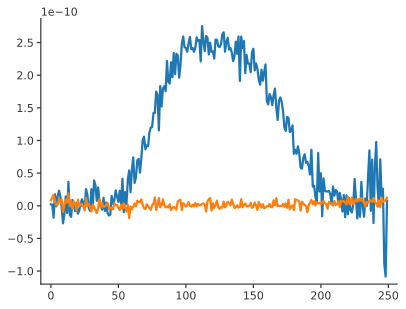

In [22]:
plt.plot(np.average(values, axis=0))
plt.plot(np.average(off_values, axis=0))

(0.0, 2.717581084821429e-10)

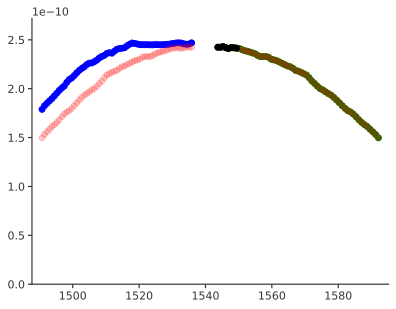

In [4]:
# we are interested in the ratio of coincidence rate per channel pair pair 
# to the raw intensity of SPDC the channel pair. Assume that the coincidence 
# rates is proportional to the minimum of the singles rate(intensity) of the 
# two channels.

interped_signal_full = np.interp(signal_full, wavelengths, data_convolved)
interped_idler_full = np.interp(idler_full, wavelengths, data_convolved)

interped_minimum = np.minimum(interped_signal_full, interped_idler_full)


plt.plot(signal_full, interped_signal_full, 'o', color='b', label='Signal')
plt.plot(idler_full, interped_idler_full, 'o', color='g', label='Idler')
plt.plot(signal_full, interped_minimum, 'o', color='r', label='Minimum', alpha=0.2)
plt.plot(idler_full, interped_minimum, 'o', color='r', label='Minimum', alpha=0.2)
plt.plot(idler_full[-8:], interped_minimum[-8:], 'o', color='k')

plt.ylim(0, 1.1*np.max(data_convolved))


In [5]:
with open("export_main_diagonal.json") as file:
    data = json.load(file)

x8_diagonal = np.array(data['x8_diagonal'])
x16_diagonal = np.array(data['x16_diagonal'])

In [6]:
ratio_8x = np.average(x8_diagonal/interped_minimum[-8:])
x60_rate_at_4amps = round(np.sum(interped_minimum*ratio_8x)/1000,2)
print(f"60x rate at 4A: {x60_rate_at_4amps} MHz")



60x rate at 4A: 3.56 MHz
